In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)
# nusc = NuScenes(version='v1.0-mini', dataroot='../../../../../../../mnt/sda1/home/Dataset', verbose=True)
nusc = NuScenes(version='v1.0-trainval', dataroot='../../data/', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 64.2 seconds.
Reverse indexing ...
Done reverse indexing in 7.1 seconds.


# Pedestrians

In [3]:
# dict with person token as key and number of moving frames as value
pedestrian_frames = dict()
# dict with scene number and number of pedestrians found in the scene
number_pedestrians = dict()

In [4]:
for n_scene in range(850):
    #print(n_scnene)
    # initialize the scene
    my_scene = nusc.scene[n_scene]
    # per scene person token database
    seen_person_tokens = []

    # first sample
    first_sample_token = my_scene['first_sample_token']
    sample = nusc.get('sample', first_sample_token)

    while True:
        for ann in sample['anns']:
            if "human.pedestrian" in nusc.get('sample_annotation', ann)['category_name'] \
            and nusc.get('sample_annotation', ann)['instance_token'] not in \
            seen_person_tokens: 
                cur_person_token = nusc.get('sample_annotation', ann)['instance_token']
                cur_person_instance = nusc.get("instance", cur_person_token)
                nbr_samples = cur_person_instance['nbr_annotations']
                
                #print("New person")
                #nusc.render_annotation(cur_person_instance['first_annotation_token'])        
                #nusc.render_annotation(cur_person_instance['last_annotation_token'])
                #plt.show()

                first_token = cur_person_instance['first_annotation_token']
                last_token = cur_person_instance['last_annotation_token']
                current_token = first_token

                moving_counter = 0
                for i in range(nbr_samples):
                    current_ann = nusc.get('sample_annotation', current_token)
                    if current_ann["attribute_tokens"]:
                        current_attr = nusc.get('attribute', current_ann['attribute_tokens'][0])['name']
                        # including pedestrians who are moving and standing
                        if current_attr.split(".")[1] != "sitting_lying_down":
                            moving_counter += 1
                            
                    current_token = current_ann["next"]

                seen_person_tokens.append(cur_person_token)
                pedestrian_frames[cur_person_token] = moving_counter

        if sample['next'] != '':
            sample = nusc.get('sample', sample['next'])
        else:
            #last sample of the scene
            break
    
    #print("Number of people in this scene: ", len(seen_person_tokens))
    number_pedestrians[str(n_scene)] = len(seen_person_tokens)

In [5]:
len(pedestrian_frames)

11512

In [6]:
with open("num_pedestrians1.txt", "w") as f:
    print(number_pedestrians, file=f, end="\n")

In [7]:
with open("num_frames_each_pedestrian1.txt", "w") as f:
    for key, value in pedestrian_frames.items():
        print(key, ":", value, file=f, end="\n")

In [8]:
non_zero_frames = {k:v for k,v in pedestrian_frames.items() if v > 0}

In [9]:
print("Number of people found for at least one frame ", len(non_zero_frames))

Number of people found for at least one frame  10434


In [10]:
with open("nonzero_frames_each_pedestrian1.txt", "w") as f:
    for key, value in non_zero_frames.items():
        print(key, ":", value, file=f, end="\n")

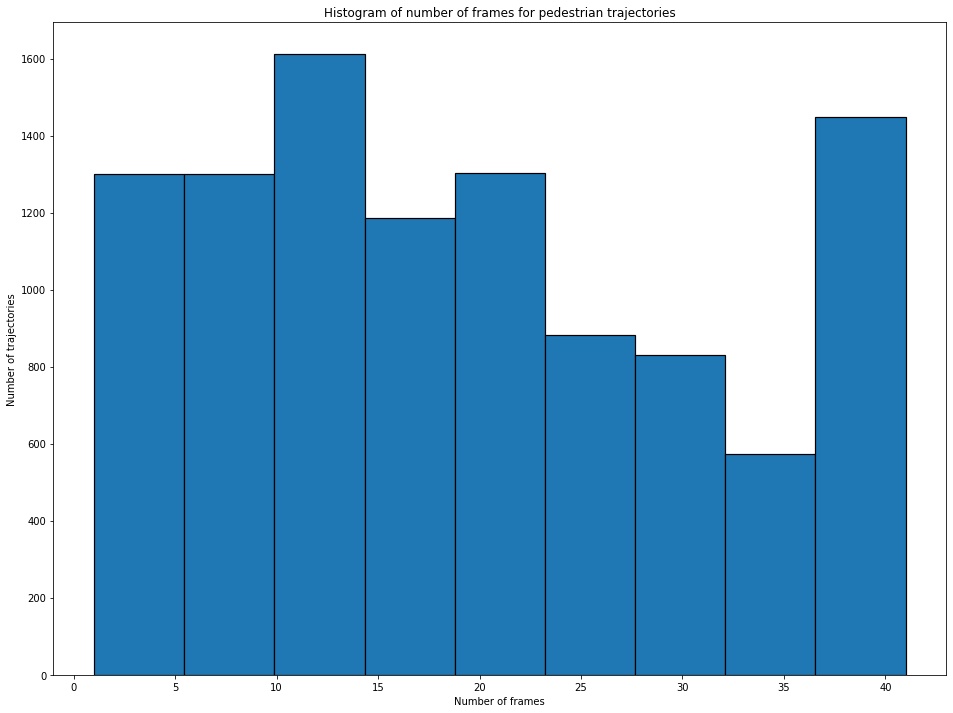

In [12]:
plt.figure(figsize=(16,12))
plt.hist(non_zero_frames.values(), bins=9, range=(1, 41), edgecolor='black', linewidth=1.2)
plt.xlabel("Number of frames")
plt.ylabel("Number of trajectories")
plt.title("Histogram of number of frames for pedestrian trajectories")
plt.savefig("../../../../../Pictures/pedestrians_histogram.png")
plt.show()

In [11]:
# calculating the average number of frames for pedestrians who have at least more than 10 frames
decent_no_of_frames = [i for i in non_zero_frames.values() if i > 10]
print("number of people found for at least 10 frames", len(decent_no_of_frames))
print("average number of frames for people found for at least 10 frames", np.mean(decent_no_of_frames))

number of people found for at least 10 frames 7532
average number of frames for people found for at least 10 frames 24.885156664896442


# Cyclists

In [19]:
# dict with person token as key and number of moving frames as value
cyclists_frames = dict()
# dict with scene number and number of pedestrians found in the scene
number_cyclists = dict()

for n_scene in range(850):
    # initialize the scene
    my_scene = nusc.scene[n_scene]
    # per scene person token database
    seen_cyclists_tokens = []

    # first sample
    first_sample_token = my_scene['first_sample_token']
    sample = nusc.get('sample', first_sample_token)

    while True:
        for ann in sample['anns']:
            if "vehicle.bicycle" in nusc.get('sample_annotation', ann)['category_name'] and \
               nusc.get('sample_annotation', ann)['instance_token'] not in seen_cyclists_tokens:
                cur_cyclist_token = nusc.get('sample_annotation', ann)['instance_token']
                cur_cyclist_instance = nusc.get("instance", cur_cyclist_token)
                nbr_samples = cur_cyclist_instance['nbr_annotations']
                
                # print(nbr_samples)
                # nusc.render_annotation(cur_person_instance['first_annotation_token'])        
                # nusc.render_annotation(cur_person_instance['last_annotation_token'])
                # plt.show()

                first_token = cur_cyclist_instance['first_annotation_token']
                last_token = cur_cyclist_instance['last_annotation_token']
                current_token = first_token

                moving_counter = 0
                for i in range(nbr_samples):
                    current_ann = nusc.get('sample_annotation', current_token)
                    if current_ann["attribute_tokens"]:
                        current_attr = nusc.get('attribute', current_ann['attribute_tokens'][0])["name"]
                        if current_attr.split(".")[1] == "with_rider":
                            moving_counter += 1


                seen_cyclists_tokens.append(cur_cyclist_token)
                cyclists_frames[cur_cyclist_token] = moving_counter

        # print(len(seen_person_tokens))
        # print(seen_person_tokens)

        if sample['next'] != '':
            sample = nusc.get('sample', sample['next'])
        else:
            #last sample of the scene
            break
    
    #print("Number of people in this scene: ", len(seen_person_tokens))
    number_cyclists[str(n_scene)] = len(seen_cyclists_tokens)

In [20]:
print("Number of bicycles found with rider", len([i for i in cyclists_frames.values() if i > 0]))

Number of bicycles found with rider 121


In [21]:
print("Number of bicycles found with rider for at least 5 frames", len([i for i in cyclists_frames.values() if i > 5]))
print("Average number of bicycles found with rider for at least 5 frames", np.mean([i for i in cyclists_frames.values() if i > 5]))

Number of bicycles found with rider for at least 5 frames 112
Average number of bicycles found with rider for at least 5 frames 24.571428571428573


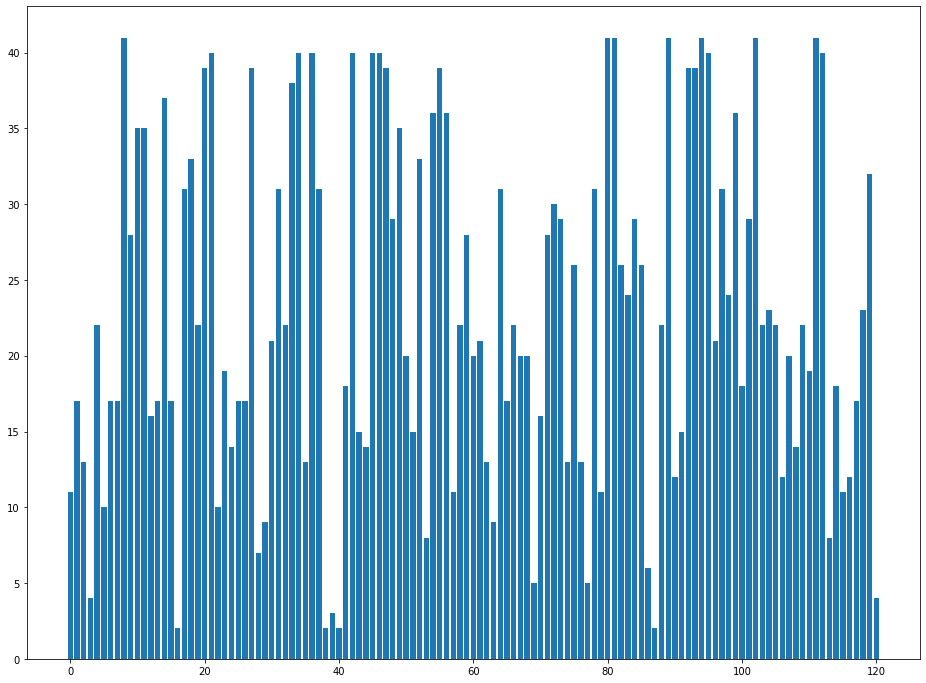

In [22]:
plt.figure(figsize=(16,12))
plt.bar(list(range(len([i for i in cyclists_frames.values() if i > 0]))), [i for i in cyclists_frames.values() if i > 0])
plt.show()